plotBase=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
plotX=[ 3  5  7  9 11 13 15 17 19 21 23 25 27 29 29 29 29 29 29 29]
plotY=[ 5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 69 69 69]


<ipython-input-1-91a1caa41497>:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


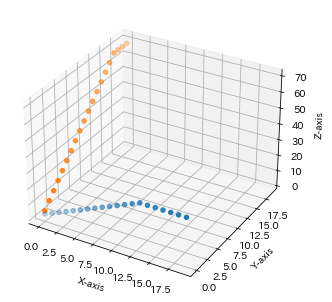

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb

# TODO:3次元プロットで2変数の線形飽和モデルをプロットする

plotBase = list(range(20))
plotX = returnListForBranchModel(inputList=plotBase, branchIndex=13, a=2, b=3)
plotY = returnListForBranchModel(inputList=plotBase, branchIndex=16, a=4, b=5)
plotX = np.array(plotX)
plotY = np.array(plotY)
plotZ = plotX+plotY

# TODO:関数コール回数が同じだが、2変数が異なる変数かつそういったものが多数ある場合が分岐線

print(f"plotBase={plotBase}\nplotX={plotX}\nplotY={plotY}")

fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plotZero = [0]*len(plotBase)
ax.scatter(plotBase, plotZero, plotX)
ax.scatter(plotZero, plotBase, plotY)

dataset01 = pd.DataFrame({"X": plotBase, "Y": plotZero, "Z": plotX})
dataset02 = pd.DataFrame({"X": plotZero, "Y": plotBase, "Z": plotY})

In [2]:
xDataSet01 = dataset01["X"].tolist()
zDataSet01 = dataset01["Z"].tolist()
yDataSet02 = dataset02["Y"].tolist()
zDataSet02 = dataset02["Z"].tolist()

In [3]:
branchIndexInDataSet01 = returnBranchIndexOfList(inputListX=xDataSet01, inputListY=zDataSet01)
branchIndexInDataSet02 = returnBranchIndexOfList(inputListX=yDataSet02, inputListY=zDataSet02)

# 説明変数が2つの分岐モデルを実装するにあたってのテストなど

1. ~\[X, Y, Z\] == \[0, Y, Z\], \[X, 0, Z\] を満たすデータ群を抽出~ -> 変数 `dataset01`, `dataset02` 
2. ~抽出した2つのデータ群から分岐点を抽出~ -> 変数 `branchIndexInDataSet01`, `branchIndexInDataSet01` 
3. 抽出した分岐点を繋ぐ直線を定義
4. データ群を定義した直線で2つに分割
5. 分割された2平面ごとにモデルを構築

In [4]:
branchIndexInDataSet01

13

In [5]:
branchIndexInDataSet02

16

In [6]:
pointA = dataset01.iloc[branchIndexInDataSet01]
pointA

X    13
Y     0
Z    29
Name: 13, dtype: int64

In [7]:
pointB = dataset02.iloc[branchIndexInDataSet02]
pointB

X     0
Y    16
Z    69
Name: 16, dtype: int64

In [8]:
dataX = []
dataY = []
dataZ = []
for index in range(0, 101, 5):
    t = index * 0.01
    dataX.append()
    dataY.append()
    dataZ.append()

TypeError: list.append() takes exactly one argument (0 given)

In [ ]:
# プロジェクト別ゼミ用資料作成

# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb

branchIndex = 11
dataBase1 = list(range(branchIndex))
dataBase2 = [branchIndex]*(21-11)
dataList1 = [3*x + 4 for x in dataBase1]
dataList2 = [3*x + 4 for x in dataBase2]
dataBase2 = list(range(11, 21))
dataListY = dataList1+dataList2
dataListX = dataBase1+dataBase2
plt.figure()
plt.plot(dataListX, dataListY)

# データ２：分岐点で異なる線形モデルに変化
branchIndex = 10
dataBase1 = list(range(branchIndex))
dataBase2 = list(range(branchIndex, 20))
dataList1 = [x + 1 for x in dataBase1]
dataList2 = [0.5*x + 6 for x in dataBase2]
dataListY = dataList1+dataList2
dataListX = dataBase1+dataBase2
plt.figure()
plt.plot(dataListX, dataListY)

# データ３：分岐点無し
branchIndex = 22
dataBase1 = list(range(branchIndex))
dataListY = [5*x + 6 for x in dataBase1]
dataListX = dataBase1
plt.figure()
plt.plot(dataListX, dataListY)

# 緊急

プロジェクト別ゼミで、分岐点検出アルゴリズムの更新にあたって、旧アルゴリズムと新アルゴリズムの比較を行う必要が出てきた。

相対誤差率・適合度の値がデータとなっている二つの表を作る。

旧アルゴリズムと新アルゴリズムとを別々のモデルとして検証する。

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb

benchmarkNamesExcludeBTSP = ["cg", "ep", "ft", "is", "lu", "mg"]
# classes = ["A", "B", "C", "D"]
classes = ["B"]
processes = [2, 4, 8, 16, 32, 64, 128, 256]
targetIndex = -1
csvDirPath = "./csv_files/"

dfByDatumExcludeBTSP = returnDFSummarizedData(
    benchmarkNames=benchmarkNamesExcludeBTSP, classes=classes, processes=processes, targetIndex=targetIndex, csvDirPath=csvDirPath)
# dfByDatumExcludeBTSP

dictForLatexTable = {}
numOfData = 0
for benchmarkName in benchmarkNamesExcludeBTSP:
    dictForLatexTable[benchmarkName] = dfByDatumExcludeBTSP[dfByDatumExcludeBTSP["benchmarkName"] == benchmarkName]
    numOfData += len(
        dfByDatumExcludeBTSP[dfByDatumExcludeBTSP["benchmarkName"] == benchmarkName])

numOfData



listForDF = []

for benchmarkName in benchmarkNamesExcludeBTSP:
    listForDF.append(returnSeriesOfDatumPerBenchmark(
        inputDF=dictForLatexTable[benchmarkName]))
DF = pd.DataFrame(listForDF)
print(DF.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
benchmarkName &      ModelIp &      ModelLog & ModelBranch &     ModelLin \\
\midrule
           CG &         0(-) & 13(11.7,11.7) & 18(0.0,0.0) &  69(0.0,0.0) \\
           EP &         0(-) &          0(-) &        0(-) & 100(0.0,0.0) \\
           FT &   9(0.0,0.0) &          0(-) &        0(-) &  91(0.0,0.0) \\
           IS &  19(0.0,0.0) &          0(-) &        0(-) &  81(0.0,0.0) \\
           LU & 30(0.0,25.9) &          0(-) &        0(-) &  70(0.0,0.0) \\
           MG &         0(-) &    3(0.5,0.5) &        0(-) &  97(0.0,3.4) \\
\bottomrule
\end{tabular}

